In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
import nimfa
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

/home/neopux/miniconda3/envs/exmc/lib/python3.7/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/home/neopux/miniconda3/envs/exmc/lib/python3.7/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


In [2]:
data_file = '/home/neopux/UHH/datasets/Video_Games_5.json'
df = pd.read_json(data_file, lines = True)

In [3]:
df.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


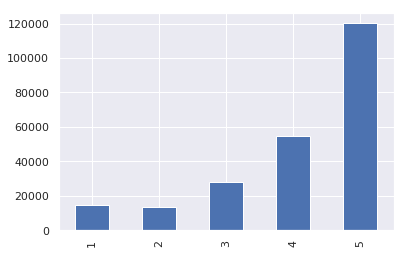

In [5]:
df.overall.value_counts(sort=False).plot(kind='bar')

In [7]:
df.shape

(231780, 9)

In [16]:
df['asin'].unique().shape

(10672,)

In [17]:
df['reviewerID'].unique().shape

(24303,)

In [18]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [19]:
df_train = df_train.copy()

In [20]:
asin = CategoricalDtype(sorted(df_train.asin.unique()), ordered=True)
rev_id = CategoricalDtype(sorted(df_train.reviewerID.unique()), ordered=True)

row_cat = df_train.reviewerID.astype(rev_id).cat
col_cat = df_train.asin.astype(asin).cat

row = row_cat.codes
col = col_cat.codes

sparse_matrix = csr_matrix((df_train["overall"].values, (row, col)), \
                           shape=(rev_id.categories.size, asin.categories.size))

In [21]:
row_cat.categories

Index(['A00263941WP7WCIL7AKWL', 'A005481137I9SCAWEF7ON',
       'A01588502N52TNG1BP7WG', 'A01803182IUSFNIFF5984',
       'A023090719X7MTBCLM19B', 'A0266076X6KPZ6CCHGVS',
       'A034294113MZYOJ6UMXUM', 'A0380485C177Q6QQNJIX',
       'A03865792TAJESCMLUT0Q', 'A049511737EMTVGTZXNKV',
       ...
       'AZYG5R26NUP70', 'AZYIAWJR9972L', 'AZYJE40XW6MFG', 'AZYOVGJLQ03ML',
       'AZYU8M791SIFC', 'AZZ1KF8RAO1BR', 'AZZHLZ8H23QD4', 'AZZKH219IDQGY',
       'AZZNK89PXD006', 'AZZTC2OYVNE2Q'],
      dtype='object', length=24274)

In [22]:
ratings = sparse_matrix.todense()

In [23]:
ratings

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
ratings.shape

In [49]:
pmf = nimfa.Psmf(sparse_matrix, rank=50, max_iter=200, rel_error=1e-5, verbose = 1, track_error = True)
pmf_fit = pmf()

In [50]:
with open(r'/home/neopux/UHH/datasets/nonnorm_basis_mx.pickle', 'wb') as handle:
    pickle.dump(pmf_fit.basis(), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'/home/neopux/UHH/datasets/nonnorm_mixture_mx.pickle', 'wb') as handle:
    pickle.dump(pmf_fit.coef(), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
W = pmf_fit.basis()
print('Basis matrix:\n%s' % W)

H = pmf_fit.coef()
print('Mixture matrix:\n%s' % H)

print('Euclidean distance: %5.3f' % pmf_fit.distance(metric='euclidean'))

#sm = pmf_fit.summary()

#print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (sm['sparseness'][0], sm['sparseness'][1]))
#print('Iterations: %d' % sm['n_iter'])
#print('Target estimate:\n%s' % np.dot(W, H))

Basis matrix:
[[1.12879691e-05 1.12879691e-05 1.12879691e-05 ... 1.12879691e-05
  1.57442285e+01 1.12879691e-05]
 [5.89825227e-05 7.59613579e-03 5.89825156e-05 ... 5.89825156e-05
  3.04168648e+02 5.89825156e-05]
 [2.12975120e-05 2.12975120e-05 2.12975120e-05 ... 5.94589992e-02
  2.12975120e-05 2.14534113e-05]
 ...
 [8.18298777e-05 1.28832467e-05 1.97077249e-02 ... 1.28800897e-05
  1.28800897e-05 1.55802755e-05]
 [1.26051141e-05 1.26047730e-05 3.05352909e+01 ... 1.26047730e-05
  1.26047730e-05 1.29683268e-05]
 [2.11311191e-05 2.11139875e-05 2.13251927e-05 ... 2.11150735e-05
  3.57116502e+01 2.11139875e-05]]
Mixture matrix:
[[5.21723957e-11 3.02392696e-11 1.80228575e-11 ... 2.37104670e-11
  9.58832380e-11 7.75644025e-12]
 [5.30829503e-11 3.02392696e-11 1.80228575e-11 ... 4.22015689e-11
  9.58832380e-11 7.75644025e-12]
 [1.03733721e-07 2.81431611e-04 1.80228575e-11 ... 5.20095392e-08
  9.59015132e-11 7.75644025e-12]
 ...
 [5.21724127e-11 3.02392696e-11 1.80228575e-11 ... 2.97730394e-11
  

In [55]:
W.shape

(24274, 50)

In [57]:
H.shape

(50, 10668)

In [60]:
preds = W * H

In [61]:
from sklearn.metrics import mean_squared_error

In [64]:
mean_squared_error(ratings, preds) ** 0.05

0.7987746310900994

In [75]:
preds_df_unmelt = pd.DataFrame(preds, columns = col_cat.categories, index = row_cat.categories)
preds_df_unmelt.index.name = 'reviewerID'
preds_df_unmelt.columns.name = 'asin'
preds_df_unmelt.head(2)

asin,0700099867,6050036071,7100027950,7293000936,8176503290,907843905X,9625990674,9861019731,9882155456,B000003SQQ,...,B00J128FPA,B00J226358,B00J6DLPLK,B00J9P3KBS,B00JM3R6M6,B00JQ8YH6A,B00JQHU9RC,B00JXW6GE0,B00KAI3KW2,B00KHECZXO
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00263941WP7WCIL7AKWL,1.140781e-08,6.479067e-09,3.861577e-09,0.003669,2.945002e-07,2.556105e-09,1.978651e-08,4.670722e-08,9.912429e-07,7.284264e-10,...,5.929648e-09,9.978265e-09,9.835851e-09,1.212900e-08,1.390002e-07,8.875097e-03,2.160884e-08,5.116919e-09,2.111927e-08,1.664742e-09
A005481137I9SCAWEF7ON,5.843863e-08,3.413003e-08,2.884808e-03,0.000002,5.650788e-06,4.459515e-06,8.162578e-06,7.296751e-07,4.127624e-05,3.806345e-09,...,4.574513e-06,3.954006e-04,7.341937e-06,6.336393e-08,6.583915e-08,1.064613e-07,1.691314e-02,3.088186e-08,1.218786e-07,2.553060e-06


In [76]:
preds_df = preds_df_unmelt.reset_index().melt('reviewerID', var_name='asin')

In [78]:
preds_df.head(2)

,reviewerID,asin,value
0,A00263941WP7WCIL7AKWL,0700099867,1.140781e-08
1,A005481137I9SCAWEF7ON,0700099867,5.843863e-08


In [100]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (18 entries)


In [81]:
df_merged = df_test.merge(preds_df, on=['reviewerID', 'asin'])

In [83]:
df_merged.shape

(69363, 10)

In [85]:
df_test.shape

(69534, 9)

In [91]:
df_merged.head(20)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,value
0,B0047TLIBU,"[31, 43]",5,"Been playing this for two days now, and I am v...","03 10, 2011",A17M1HL6U2GS7M,Storylover,It feels like hanging out with old friends aga...,1299715200,5.993661e-04
1,B0053BCP40,"[0, 0]",4,"I really enjoyed playing this game, although i...","02 27, 2014",A1FGU7F9UJ264N,Kelly Randall,Fun game,1393459200,2.271945e-07
2,B000WCQWR6,"[0, 0]",3,This was kind of a gamble and was looking for ...,"07 7, 2013",A3R7M2EP1EYNVT,Thomas B. Hileman Jr.,Shoot em up,1373155200,3.205947e-02
3,B00498T500,"[4, 4]",4,***Updated 7/7/2011 - update marked below***I ...,"04 10, 2011",A369KP0JV77JYT,Jon,"Fun for a group, don't pay too much for it",1302393600,6.258070e-03
4,B00005BIG7,"[3, 3]",5,It looks like we've come a long way from past ...,"07 13, 2001",ABIKTKAWOMY8,Chance Farley,One of the best fps's to ever hit a console,994982400,5.010131e-03
5,B002CYWJWO,"[7, 8]",4,"Tellurye, here with another review brought to ...","10 30, 2009",A2SYA663GK3EEJ,"R. Stevens ""Fedora Technologies""","Does the Saw universe justice, but controls ma...",1256860800,2.050861e-04
6,B001V9PTVE,"[2, 2]",4,Fallout 2 is worth the price alone... but if y...,"09 6, 2009",A39AUQ3IP3C8KI,J. Nicholson,Worth it (even if it was just FO2),1252195200,6.256847e-09
7,B00DBDPOZ4,"[1, 1]",5,"As I'm not a fan of AA batteries, this accesso...","12 4, 2013",A22N09ZP9D77DM,D. Alvarado,Great upgrade over the Xbox 360 version.,1386115200,1.186235e-01
8,B0009A4EV2,"[4, 4]",5,"Next to the Final Fantasy series, the Dragon Q...","03 22, 2007",AJKWF4W7QD4NS,"N. Durham ""Big Evil""","One of the best games, ever, for the PS2",1174521600,4.627793e-01
9,B00002EQAP,"[0, 0]",5,"This game is so great, not just for the crazy ...","08 20, 2013",A1T4HGVX32QIYC,Will Ramirez,Great Game,1376956800,4.788158e-09


In [101]:
mean_squared_error(df_merged.overall, df_merged.value) ** 0.5

4.226522013061119

In [105]:
sum((df_merged.overall - df_merged.value) < 3)

17259

In [109]:
idx = ((df_merged.overall - df_merged.value < 1) & (df_merged.overall > 1))

In [110]:
df_merged[idx].shape

(23, 10)

### Make predictions

In [ ]:
df.

## RESULTS
k = 50, iter = 20: Euclidean distance: 3099609.494
k = 50, iter = 50 Euclidean distance: 2895407.006

# Surprise

In [29]:
from surprise import Dataset, Reader, SVD, NormalPredictor, BaselineOnly
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

In [25]:
reader = Reader(rating_scale=(1, 5))

ds = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

In [47]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
res = cross_validate(algo, ds, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0738  1.0741  1.0788  1.0838  1.0675  1.0756  0.0055  
MAE (testset)     0.8249  0.8247  0.8277  0.8329  0.8239  0.8268  0.0033  
Fit time          6.02    6.21    6.32    6.03    6.20    6.16    0.12    
Test time         0.19    0.23    0.23    0.19    0.72    0.31    0.20    


In [26]:
tr, ts = train_test_split(ds, random_state=42, test_size=0.3)


In [35]:
algo = NormalPredictor()
algo.fit(tr)

In [36]:
predictions = algo.test(ts)

In [37]:
predictions

[Prediction(uid='A374AVSH2B04JV', iid='B00111SFEU', r_ui=5.0, est=4.7706718996359365, details={'was_impossible': False}),
 Prediction(uid='A3CJAA5VWKC7X2', iid='B00DB9JYFY', r_ui=2.0, est=3.461434019803055, details={'was_impossible': False}),
 Prediction(uid='A39DQIQ1GO2J4Y', iid='B004KKI7XI', r_ui=3.0, est=4.467922611126574, details={'was_impossible': False}),
 Prediction(uid='AMPV2QQJFW6HJ', iid='B003ZULWQI', r_ui=1.0, est=3.3738067842129866, details={'was_impossible': False}),
 Prediction(uid='A2LEI2R6UTR1QJ', iid='B009K6YJTS', r_ui=2.0, est=3.6783433309162876, details={'was_impossible': False}),
 Prediction(uid='A1FZNCX1PBUU2O', iid='B00005ML10', r_ui=5.0, est=3.728566484387304, details={'was_impossible': False}),
 Prediction(uid='A2AIBHOQVU9IRB', iid='B002I0GZ5Y', r_ui=5.0, est=4.452719242201051, details={'was_impossible': False}),
 Prediction(uid='ASESZ0QO8RRDE', iid='B003O6E3C8', r_ui=5.0, est=4.708483650465303, details={'was_impossible': False}),
 Prediction(uid='A1LWQ0DT5SCMYR

In [38]:
accuracy.rmse(predictions)

RMSE: 1.5565


1.5564754596096395

In [39]:
accuracy.mae(predictions)

MAE:  1.1908


1.1908013108846844

In [52]:
algo = SVD(n_factors = 50, n_epochs = 1000, biased = True)
res = algo.fit(tr)

In [49]:
predictions = algo.test(ts)

In [50]:
accuracy.rmse(predictions)

RMSE: 1.0906


1.090624202515731

In [51]:
accuracy.mae(predictions)

MAE:  0.8153


0.8152870909315836